# Recommender Systems
## Writing A Machine Learning Algorithm for Recommending Movies

In dit script probeer ik een algoritme te schrijven die de beoordeling van films gaat voorspellen voor mensen. Recommender Systems worden gebruikt door bedrijven zoals YouTube en Netflix om jou langer op hun platform te houden. Ook kan het gebruikt worden door online kledingwinkels die willen voorspellen welke kleding jij leuk vindt.

De dataset die wordt gebruikt is de MovieLens database. Deze is te vinden op [grouplens.org/](https://grouplens.org/datasets/movielens/). Daarnaast volg ik een stappenplan die is beschreven in [towardsdatascience.com](https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d.)

In [43]:
import pandas as pd 
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [38]:
# Het inladen van de dataset. Kies voor de kleine of de grote dataset aan de hand van je doel. 
# De grote dataset duurt lang om in te laden, maar zal wel betere resultaten leveren
BigDataSet = False
DataSet = "data" if BigDataSet else "data_small"
df = pd.read_csv(DataSet + '/ratings.csv', sep=',', names=['userID','movieID','rating','timestamp'], header = 0)
df.head()

,userID,movieID,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Door de movies.csv dataset samen te voegen met de ratings.csv kunnen we de ratings koppelen aan een film

In [39]:
movieTitles = pd.read_csv(DataSet + '/movies.csv', names=['movieID','title','genres'], header = 0)
df = pd.merge(df, movieTitles, on='movieID')
df.head()

,userID,movieID,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


Dit is wat elke kolom betekent:
- `userID` is de ID van elke gebruiker. 
- `movieID` is de ID van elke film. 
- `rating` is de beoordeling van de gebruiker `userID` op film `movieID`. Dit kan een waarde zijn tussen 1 en 5
- `timestamp` is de tijd dat de film beoordeeld was
- `title` is de naam van de film en uit welk jaar die kwam
- `genres` zijn de verschillende soorten genres van de film

Met de commando's `describe` krijgen we een samenvatting van onze dataset. 

In [40]:
df.describe(include='all')

,userID,movieID,rating,timestamp,title,genres
count,100836.000000,100836.000000,100836.000000,1.008360e+05,100836,100836
unique,NaN,NaN,NaN,NaN,9719,951
top,NaN,NaN,NaN,NaN,Forrest Gump (1994),Comedy
freq,NaN,NaN,NaN,NaN,329,7196
mean,326.127564,19435.295718,3.501557,1.205946e+09,NaN,NaN
std,182.618491,35530.987199,1.042529,2.162610e+08,NaN,NaN
min,1.000000,1.000000,0.500000,8.281246e+08,NaN,NaN
25%,177.000000,1199.000000,3.000000,1.019124e+09,NaN,NaN
50%,325.000000,2991.000000,3.500000,1.186087e+09,NaN,NaN
75%,477.000000,8122.000000,4.000000,1.435994e+09,NaN,NaN


We zien wat interessante dingen. De dataset heeft 100837 beoordelingen met 611 unieke gebruikers en 9725 unieke films. Daarnaast is de meest beoordeelde film Forrest Gump uit 1994. Deze film is 329 keer beoordeeld. 

Nu kunnnen we een data frame maken met de gemiddelde beoordeling en het aantal beoordelingen. Hiermee is het mogelijk een correlatie coefficient uit te rekenen. Om deze dataset te krijgen gebruiken we de `groupby` functie. We groeperen op de `title` en pakken het gemiddelde van `rating`.

In [52]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


Daarnaast willen we een kolom met de `numberOfRatings` waarin staat hoeveel ratings een film heeft gekregen. Dit doen we ook met de `groupby` functie, maar  we kiezen ervoor om de ratings te tellen met `count`.

In [54]:
ratings['numberOfRatings'] = df.groupby('title')['rating'].count()
ratings.head()

,rating,number_of_ratings,numberOfRatings
title,,,
'71 (2014),4.0,1,1
'Hellboy': The Seeds of Creation (2004),4.0,1,1
'Round Midnight (1986),3.5,2,2
'Salem's Lot (2004),5.0,1,1
'Til There Was You (1997),4.0,2,2


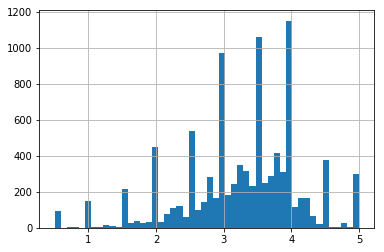

In [58]:
ratings['rating'].hist(bins=50)

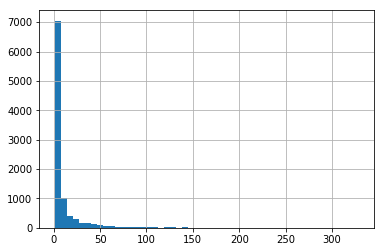

In [59]:
ratings['numberOfRatings'].hist(bins=50)

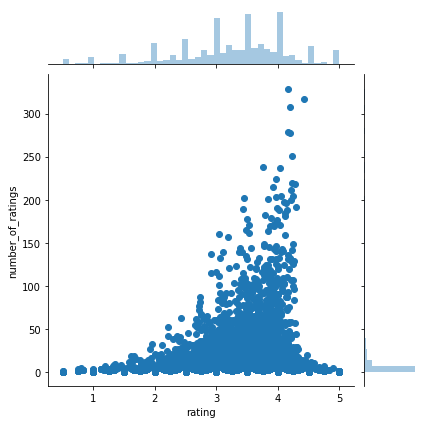

In [60]:
import seaborn as sns
sns.jointplot(x='rating', y='number_of_ratings', data=ratings)

Deze diagram geeft een belangrijk feit weer over onze data. Hoe meer ratings de film heeft gehad, hoe groteer de kans is dat deze film een goeie rating heeft.

Laten we de Content Based recommender system maken. Het format van een tabel zoals weergegeven in de coursera course van Andrew Ng is een 

In [63]:
movie_matrix = df.pivot_table(index='userID', columns='title', values='rating')
movie_matrix.head()

,rating,number_of_ratings,numberOfRatings
title,,,
Forrest Gump (1994),4.164134,329,329
"Shawshank Redemption, The (1994)",4.429022,317,317
Pulp Fiction (1994),4.197068,307,307
"Silence of the Lambs, The (1991)",4.161290,279,279
"Matrix, The (1999)",4.192446,278,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251,251
Jurassic Park (1993),3.750000,238,238
Braveheart (1995),4.031646,237,237
Terminator 2: Judgment Day (1991),3.970982,224,224
